In [602]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import boxcox, yeojohnson
from matplotlib import pyplot as plt
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, GRU, Dropout
from keras.wrappers.scikit_learn import KerasRegressor

In [603]:
df = pd.read_csv('data/processed_dataset.csv')

In [604]:
df.head()

,Date,Latitude,Longitude,Altitude,NO2,PM2.5,O3,PM10,temperature_2m (°C),relative_humidity_2m (%),...,soil_temperature_0_to_7cm (°C),soil_moisture_0_to_7cm (m³/m³),is_day (),PM2.5/N02,PM2.5/03,Weekend,Season_Autumn,Season_Spring,Season_Summer,Season_Winter
0,2023-02-15 19:35:00+00:00,46.234818,15.267305,240.0,4.248495,4.262680,0.857538,4.499810,0.5,91.0,...,0.384574,-1.055553,0.0,0.014185,4.416369,0,False,False,False,True
1,2023-02-15 20:15:00+00:00,46.234818,15.267305,240.0,4.025352,4.330733,2.000000,4.454347,0.1,92.0,...,0.195874,-1.055553,0.0,0.305382,3.637586,0,False,False,False,True
2,2023-02-15 20:35:00+00:00,46.234818,15.267305,240.0,4.025352,4.330733,2.000000,4.454347,0.1,92.0,...,0.195874,-1.055553,0.0,0.305382,3.637586,0,False,False,False,True
3,2023-02-15 21:15:00+00:00,46.234818,15.267305,240.0,3.871201,4.290459,2.000000,4.356709,-1.1,93.0,...,0.098930,-1.055553,0.0,0.419258,3.597312,0,False,False,False,True
4,2023-02-15 21:35:00+00:00,46.234818,15.267305,240.0,3.871201,4.290459,2.000000,4.356709,-1.1,93.0,...,0.098930,-1.055553,0.0,0.419258,3.597312,0,False,False,False,True


In [605]:
df.isnull().sum()

Date                              0
Latitude                          0
Longitude                         0
Altitude                          0
NO2                               0
PM2.5                             0
O3                                0
PM10                              0
temperature_2m (°C)               0
relative_humidity_2m (%)          0
dew_point_2m (°C)                 0
apparent_temperature (°C)         0
precipitation (mm)                0
rain (mm)                         0
snowfall (cm)                     0
surface_pressure (hPa)            0
cloud_cover (%)                   0
wind_speed_10m (km/h)             0
wind_direction_10m (°)            0
soil_temperature_0_to_7cm (°C)    0
soil_moisture_0_to_7cm (m³/m³)    0
is_day ()                         0
PM2.5/N02                         0
PM2.5/03                          4
Weekend                           0
Season_Autumn                     0
Season_Spring                     0
Season_Summer               

In [606]:
# delete rows with null values
df.dropna(inplace=True)

In [607]:
df.isnull().sum()

Date                              0
Latitude                          0
Longitude                         0
Altitude                          0
NO2                               0
PM2.5                             0
O3                                0
PM10                              0
temperature_2m (°C)               0
relative_humidity_2m (%)          0
dew_point_2m (°C)                 0
apparent_temperature (°C)         0
precipitation (mm)                0
rain (mm)                         0
snowfall (cm)                     0
surface_pressure (hPa)            0
cloud_cover (%)                   0
wind_speed_10m (km/h)             0
wind_direction_10m (°)            0
soil_temperature_0_to_7cm (°C)    0
soil_moisture_0_to_7cm (m³/m³)    0
is_day ()                         0
PM2.5/N02                         0
PM2.5/03                          0
Weekend                           0
Season_Autumn                     0
Season_Spring                     0
Season_Summer               

In [608]:
df.shape

(5621, 29)

In [609]:
output_col = 'PM10'

input_cols = df.columns.tolist()
input_cols.remove(output_col)
input_cols.remove('Date')

information_gain_scores = mutual_info_regression(df[input_cols], df[output_col])

feature_importances = pd.Series(information_gain_scores, index=input_cols)
feature_importances.name = 'Information Gain Scores'
feature_importances.sort_values(ascending=False, inplace=True)

feature_importances.head(10)

PM2.5                             1.526402
PM2.5/03                          0.806475
PM2.5/N02                         0.555866
soil_moisture_0_to_7cm (m³/m³)    0.507550
dew_point_2m (°C)                 0.398878
soil_temperature_0_to_7cm (°C)    0.388567
apparent_temperature (°C)         0.331988
NO2                               0.318007
temperature_2m (°C)               0.310090
O3                                0.304246
Name: Information Gain Scores, dtype: float64

In [610]:
top_4_features = feature_importances.head(4).index.tolist()
print(top_4_features)

['PM2.5', 'PM2.5/03', 'PM2.5/N02', 'soil_moisture_0_to_7cm (m³/m³)']


In [611]:
target = "PM10"
features = top_4_features + [target]
dataset = df[features]

In [612]:
dataset.head()

,PM2.5,PM2.5/03,PM2.5/N02,soil_moisture_0_to_7cm (m³/m³),PM10
0,4.262680,4.416369,0.014185,-1.055553,4.499810
1,4.330733,3.637586,0.305382,-1.055553,4.454347
2,4.330733,3.637586,0.305382,-1.055553,4.454347
3,4.290459,3.597312,0.419258,-1.055553,4.356709
4,4.290459,3.597312,0.419258,-1.055553,4.356709


In [613]:
dataset.shape

(5621, 5)

In [614]:
test_split = round(len(dataset) * 0.2)

In [615]:
train_data = dataset[:-1041]
test_data = dataset[-1041:]

In [616]:
print(train_data.shape, test_data.shape)

(4580, 5) (1041, 5)


In [617]:
scaler = MinMaxScaler(feature_range=(0, 1))

train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

In [618]:
def create_time_series(data, n_past):
    X, y = [], []
    for i in range(n_past, len(data)):
        X.append(data[i - n_past:i, 0:data.shape[1]])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

In [619]:
window_size = 30
X_train, y_train = create_time_series(train_data, window_size)
X_test, y_test = create_time_series(test_data, window_size)

In [620]:
print(X_train.shape, y_train.shape)

(4550, 30, 5) (4550,)


In [621]:
print(X_test.shape, y_test.shape)

(1011, 30, 5) (1011,)


In [632]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(30, 5)))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

In [633]:
history = model.fit(X_train, y_train, epochs=10, batch_size=72, validation_data=(X_test, y_test), verbose=1,
                    shuffle=False)

Epoch 1/10
64/64 [==============================] - 4s 21ms/step - loss: 0.0377 - val_loss: 0.0372
Epoch 2/10
64/64 [==============================] - 1s 18ms/step - loss: 0.0149 - val_loss: 0.0340
Epoch 3/10
64/64 [==============================] - 1s 17ms/step - loss: 0.0133 - val_loss: 0.0324
Epoch 4/10
64/64 [==============================] - 1s 17ms/step - loss: 0.0121 - val_loss: 0.0292
Epoch 5/10
64/64 [==============================] - 1s 18ms/step - loss: 0.0107 - val_loss: 0.0272
Epoch 6/10
64/64 [==============================] - 1s 18ms/step - loss: 0.0101 - val_loss: 0.0247
Epoch 7/10
64/64 [==============================] - 1s 17ms/step - loss: 0.0093 - val_loss: 0.0227
Epoch 8/10
64/64 [==============================] - 1s 17ms/step - loss: 0.0087 - val_loss: 0.0208
Epoch 9/10
64/64 [==============================] - 1s 17ms/step - loss: 0.0081 - val_loss: 0.0195
Epoch 10/10
64/64 [==============================] - 1s 17ms/step - loss: 0.0077 - val_loss: 0.0181


In [634]:
prediction = model.predict(X_test)

32/32 [==============================] - 0s 3ms/step


In [635]:
prediction.shape

(1011, 1)

In [636]:
X_test.shape

(1011, 30, 5)

In [637]:
prediction_copies_array = np.repeat(prediction, 5, axis=-1)

In [638]:
prediction_copies_array.shape

(1011, 5)

In [639]:
pred = scaler.inverse_transform(np.reshape(prediction_copies_array, (len(prediction), 5)))[:, 0]

In [640]:
pred.shape

(1011,)

In [641]:
original_copies_array = np.repeat(y_test, 5, axis=-1)
original = scaler.inverse_transform(np.reshape(original_copies_array, (len(y_test), 5)))[:, 0]

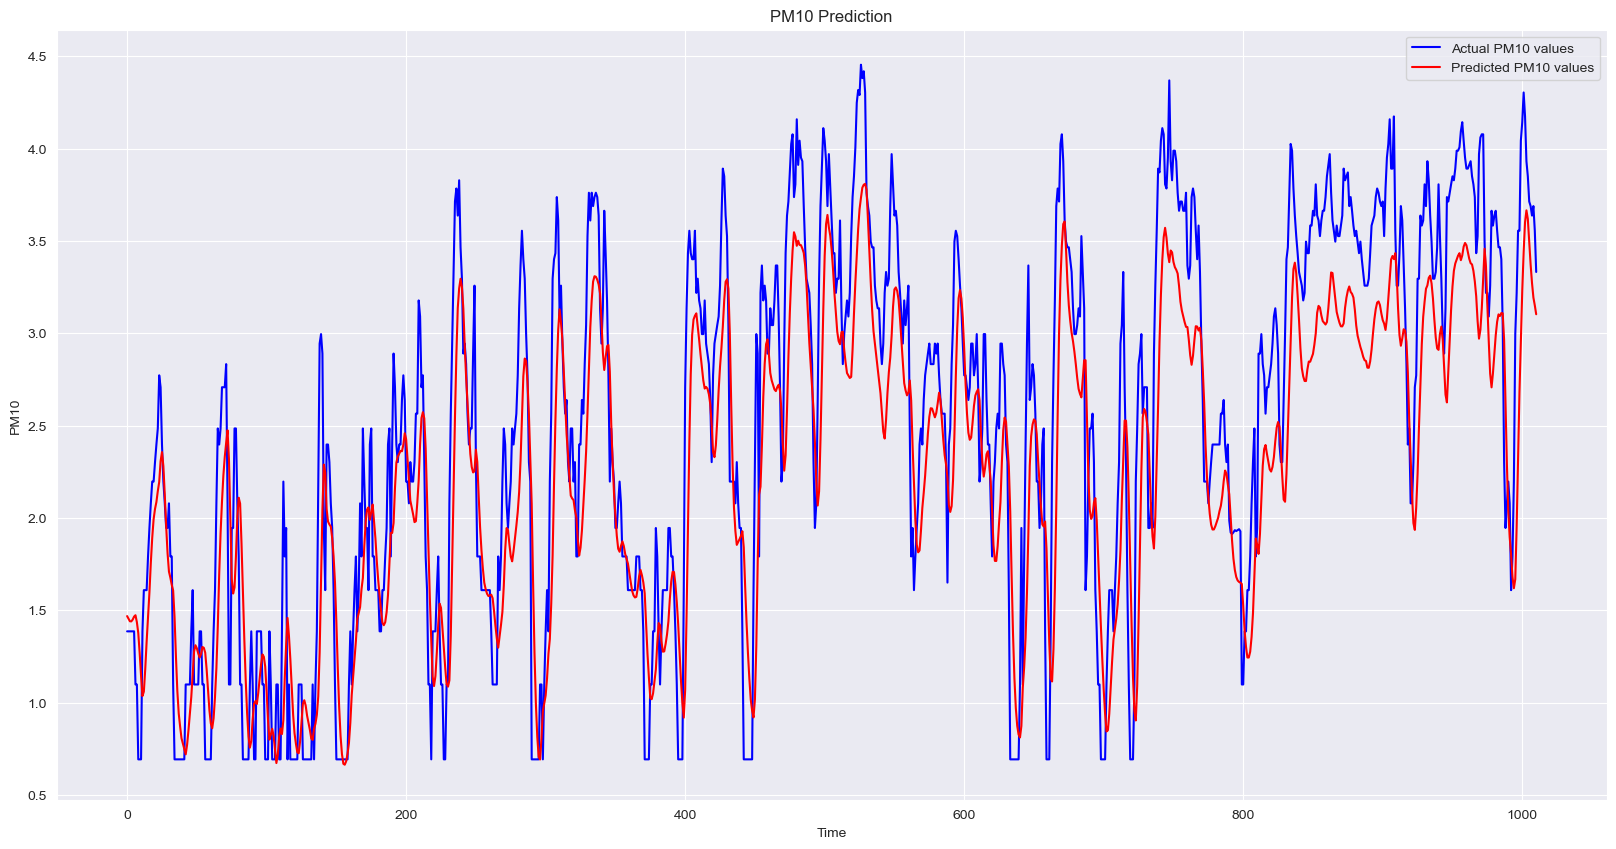

In [642]:
plt.figure(figsize=(20, 10))
plt.plot(original, color='blue', label='Actual PM10 values')
plt.plot(pred, color='red', label='Predicted PM10 values')
plt.title('PM10 Prediction')
plt.xlabel('Time')
plt.ylabel('PM10')
plt.legend()
plt.show()

In [643]:
df_output = pd.DataFrame({'Actual': original, 'Predicted': pred})
df_output.head()

,Actual,Predicted
0,1.386294,1.468934
1,1.386294,1.454329
2,1.386294,1.440871
3,1.386294,1.440211
4,1.386294,1.449841
